In [ ]:
# !pip install fbprophet

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

## 데이터 로드

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data/양주연_stat.csv'
df = pd.read_csv(path, header=0)
print(df.shape)
print(df.head())

(442, 6)
   searchDate  dailyViewCount  ...  favorablePercent  activePercent
0  2019-12-01            5974  ...                97             58
1  2019-12-02            9119  ...                96             42
2  2019-12-03            6745  ...                97             37
3  2019-12-04            4109  ...                97             30
4  2019-12-05            4250  ...                97             31

[5 rows x 6 columns]


## 불필요한 컬럼 삭제(단변량 예측)

In [ ]:
del df['dailyViewCount']
del df['videoCount']
del df['favorablePercent']
del df['activePercent']

In [ ]:
# 데이터의 마지막 날짜와 그 다음 날짜를 저장
lastday = df['searchDate'][len(df)-1]
nextday = str(pd.date_range(lastday, periods=2)[1])[:10]
print("마지막 날짜 : {}, 예측 시작 날짜 : {}".format(lastday, nextday))

마지막 날짜 : 2021-02-16, 예측 시작 날짜 : 2021-02-17


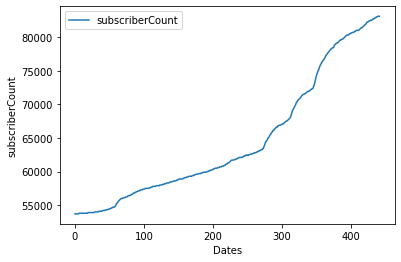

In [ ]:
df.plot()
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.show()

## 모델에 맞게 데이터 전처리

In [ ]:
# 컬럼명 변경
df.columns = ['ds', 'y']
# 데이터 타입 변경
df['ds']= pd.to_datetime(df['ds'])

In [ ]:
preday = 30

In [ ]:
fast_10day = str(pd.date_range(df['ds'][len(df)-preday], periods=preday)[0])[:10]

In [ ]:
y_true = df['y'][-preday:].values

# train set 마지막 preday일 날짜 예측 검증
last_10day = list()
for i in range(preday):
    last_10day.append(str(pd.date_range(fast_10day, periods=preday)[i])[:10])
last_10day = pd.DataFrame(last_10day, columns = ['ds'])
last_10day['ds']= pd.to_datetime(last_10day['ds'])

In [ ]:
from fbprophet import Prophet

# 모델 생성
model = Prophet()
# 모델 학습
model.fit(df)

forecast = model.predict(last_10day)
y_pred = forecast['yhat'].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


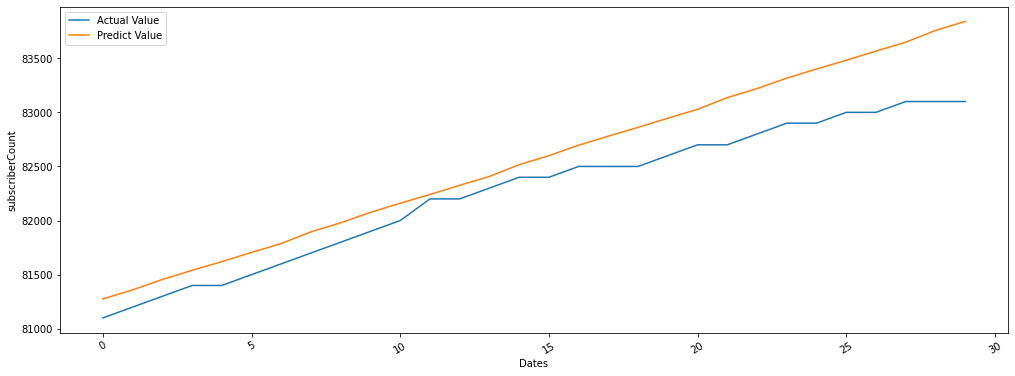

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(y_true, label="Actual Value")
plt.plot(y_pred, label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(rotation = 30)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('prophet - MAE 값 : %.3f' % mae)

prophet - MAE 값 : 294.115


## 예측할 일 수 입력

In [ ]:
# 예측할 날짜 일 수
predict_day = 9
# 예측 날짜 문자열 리스트 생성
pred_date = list()
for i in range(predict_day):
    pred_date.append(str(pd.date_range(nextday, periods=predict_day)[i])[:10])

# 날짜 리스트를 데이터 프레임 화
pred_date = pd.DataFrame(pred_date, columns = ['ds'])
# 문자열을 날짜 데이터 형식으로 변환
pred_date['ds']= pd.to_datetime(pred_date['ds'])

## 시각화

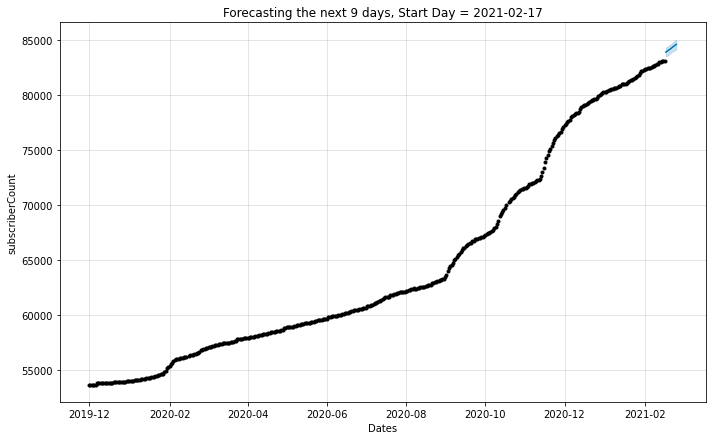

In [ ]:
# 미래 예측
forecast = model.predict(pred_date)
model.plot(forecast)
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {predict_day} days, Start Day = {nextday}")
plt.show()

In [ ]:
# 기존 데이터 마지막 날의 다음 날을 구함(= 미래 예측 데이터의 시작 날짜)
next = str(pd.date_range(df['ds'][len(df)-1], periods=2)[1])[:10]

step = 9
# 예측 데이터 날짜 리스트 생성
forecast_date = []
for i in range(step):
  forecast_date.append(str(pd.date_range(next, periods=step)[i])[:10])

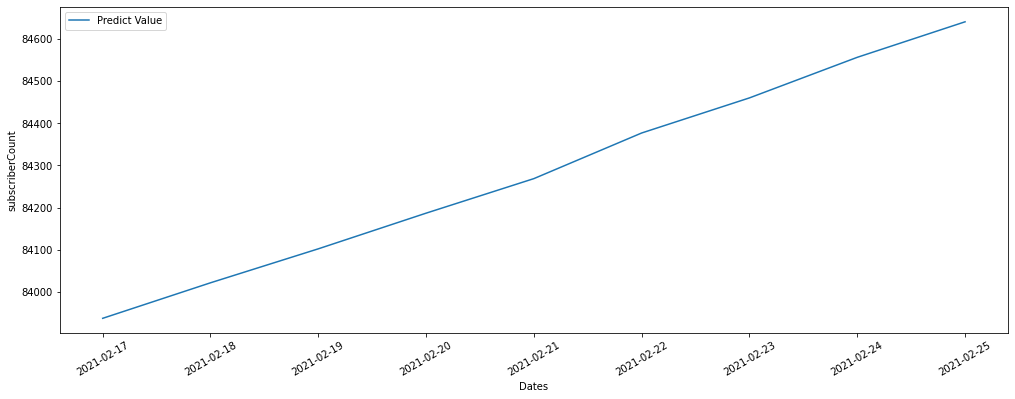

In [ ]:
plt.figure(figsize=(17,6))
plt.plot(forecast['yhat'], label="Predict Value")
plt.ylabel("subscriberCount")
plt.xlabel("Dates")
plt.xticks(list(range(step)), forecast_date, rotation = 30)
plt.legend()
plt.show()

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-17,83927.342789,83569.383448,84355.936566,83927.342789,83927.342789,9.298987,9.298987,9.298987,9.298987,9.298987,9.298987,0.0,0.0,0.0,83936.641776
1,2021-02-18,84015.955714,83597.555936,84403.085228,84015.955714,84015.955714,5.092567,5.092567,5.092567,5.092567,5.092567,5.092567,0.0,0.0,0.0,84021.048281
2,2021-02-19,84104.568639,83681.733454,84509.639206,84104.568639,84104.568639,-2.791311,-2.791311,-2.791311,-2.791311,-2.791311,-2.791311,0.0,0.0,0.0,84101.777329
3,2021-02-20,84193.181565,83802.110861,84586.907447,84193.181565,84193.181565,-6.627584,-6.627584,-6.627584,-6.627584,-6.627584,-6.627584,0.0,0.0,0.0,84186.553981
4,2021-02-21,84281.794490,83901.351346,84646.926331,84271.972341,84289.349945,-13.141482,-13.141482,-13.141482,-13.141482,-13.141482,-13.141482,0.0,0.0,0.0,84268.653008
5,2021-02-22,84370.407416,83981.342770,84764.983956,84347.530904,84389.696195,6.684791,6.684791,6.684791,6.684791,6.684791,6.684791,0.0,0.0,0.0,84377.092207
6,2021-02-23,84459.020341,84047.383953,84860.453639,84416.492043,84493.587791,1.484031,1.484031,1.484031,1.484031,1.484031,1.484031,0.0,0.0,0.0,84460.504372
7,2021-02-24,84547.633266,84130.580429,84979.484859,84483.429321,84600.763022,9.298987,9.298987,9.298987,9.298987,9.298987,9.298987,0.0,0.0,0.0,84556.932253
8,2021-02-25,84636.246192,84193.887668,85070.822211,84539.472351,84714.541491,5.092567,5.092567,5.092567,5.092567,5.092567,5.092567,0.0,0.0,0.0,84641.338758


In [ ]:
# yhat은 미래 예측 값, yhat_lower은 예측 하한값, yhat_upper은 예측 상한값
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2021-02-17  83936.641776  83569.383448  84355.936566
1 2021-02-18  84021.048281  83597.555936  84403.085228
2 2021-02-19  84101.777329  83681.733454  84509.639206
3 2021-02-20  84186.553981  83802.110861  84586.907447
4 2021-02-21  84268.653008  83901.351346  84646.926331
5 2021-02-22  84377.092207  83981.342770  84764.983956
6 2021-02-23  84460.504372  84047.383953  84860.453639
7 2021-02-24  84556.932253  84130.580429  84979.484859
8 2021-02-25  84641.338758  84193.887668  85070.822211


In [ ]:
arr = forecast['yhat']

In [ ]:
int(arr[0])

83936

In [ ]:
for i in arr :
  print(int(i))

83936
84021
84101
84186
84268
84377
84460
84556
84641
